To make the plots in this tutorial interactive, you will need to have `ipympl` [installed in your environment](https://matplotlib.org/ipympl/installing.html). Once this is installed, run the following cell:

In [1]:
# NBVAL_SKIP
# Run this cell to make the plots interactive!
%matplotlib widget 

# Analysing NanoVer recordings using MDAnalysis

The aim of this notebook is to demonstrate how recordings of simulations created using the recording feature in NanoVer can be analysed using MDAnalysis. We will use a pre-prepared recording of an OpenMM simulation of the methane + nanotube system examined in the [OpenMM nanotube tutorial](../openmm/openmm_nanotube.ipynb). If you're looking for a challenge, check out our [OpenMM polyalanine simulation notebook](../openmm/openmm_polyalanine.ipynb) first to learn how to record your own iMD-VR simulation to analyse!

We will examine a pre-prepared trajectory produced during a simulation of the methane + nanotube system, in which a user interacts with the carbon atom of the methane to pull the methane around in space, through the nanotube in one direction, and then back through the nanotube in the other direction. When running this simulation, the forces and velocities of the atoms in the system were explicitly included in the data output from the simulation.

## Visualise the recording (Optional)

If you don't want to visualise the recording, skip straight to the next section!

You can visualise this trajectory in VR by passing the recorded simulation as a `PlaybackSimulation` to an `OmniRunner` and connecting to the server. More detailed instructions can be found in the [OpenMM polyalanine simulation notebook](../openmm/openmm_polyalanine.ipynb). To serve the recorded simulation, run the cell below: 

In [2]:
from nanover.omni import OmniRunner
from nanover.recording import PlaybackSimulation

nanotube_recording = PlaybackSimulation.from_path(path="files/nanotube-recording.nanover.zip")
recording_runner = OmniRunner.with_basic_server(nanotube_recording, name='nanotube-recording-server')
recording_runner.next()

Now you can connect to the server using NanoVer iMD-VR to view the recorded simulation in VR. Note that as it is a recording, you will not be able to interact with the system yourself.

When you have finished watching the recording, run the following cell to close the server:

In [3]:
recording_runner.close()

## Retrieving data from the recorded trajectory

To analyse the trajectory using MDAnalysis, we first need to load it as an MDAnalysis universe. This can be achieved using functionality from the `nanover.mdanalysis` module. Let's import the relevant modules—while we're at it we'll import `numpy` and `matplotlib.pyplot`, as they'll come in handy for analysing the data.

In [4]:


from nanover.mdanalysis import universe_from_recording, universes_from_recording

import matplotlib.pyplot as plt
import numpy as np

Now we need to convert our recorded trajectory to an MDAnalysis universe. The way this is done depends on the type of recording you are dealing with:

- If your recording contains a **single session** with no resets, you can use the `universe_from_recording` method to parse your recorded trajectory.
- If your recording contains **multiple sessions and/or resets**, you need to use the `universes_from_recording` method to parse your recorded trajectory.

### Single session parsing

Let's convert the recorded trajectory for the methane + nanotube simulation. The function `universe_from_recording` parases the recorded trajectory and returns an MDAnalysis universe.

In [ ]:
# Define the path to the recorded trajectory
nanotube_recording_path = 'files/nanotube-recording.nanover.zip'

# Create the MDAnalysis universe from the NanoVer recorded trajectory
u = universe_from_recording(nanotube_recording_path)

In [ ]:
# We have our recorded session of the methane + nanotube simulation as a universe of 65 atoms and a trajectory of 1468 frames
print(u, u.trajectory)

Great, we have our methane + nanotube universe! Now we can use the functionality of MDAnalysis to retrieve the data from the recording.

In [ ]:
# Create empty lists to append simulation data to

frames = []                        # Frame indices
simulation_times = []              # Time elapsed in simulation time
timestamps = []                    # Timestamps for synchronising trajectory and state data

potential_energy = []              # Potential energy of the system
kinetic_energy = []                # Kinetic energy of the system

particle_positions = []            # Positions of the particles
particle_velocities = []           # Velocities of the particles
particle_forces_system = []        # Forces acting on the particles (excluding user forces)

user_energy = []                   # Potential energy of the user interaction
user_forces = []                   # iMD forces acting on the particles 

# Iterate through simulation frames and retrieve simulation data, skipping the first frame
for timestep in u.trajectory:
    if timestep.frame != 0:
        frames.append(timestep.frame)
        simulation_times.append(timestep.time)
        timestamps.append(timestep.data["elapsed"])
        
        potential_energy.append(timestep.data["energy.potential"])
        kinetic_energy.append(timestep.data["energy.kinetic"])
        
        particle_positions.append(u.atoms.positions)
        particle_velocities.append(u.atoms.velocities)
        particle_forces_system.append(u.atoms.forces)
        
        user_energy.append(timestep.data["energy.user.total"])
        user_forces.append(timestep.data["user_forces"])

**IMPORTANT**: The base units of MDAnalysis differ from those of NanoVer and OpenMM as follows:

|  Quantity   |  NanoVer/OpenMM   | MDAnalysis |
|:-----------:|:-----------------:|:----------:|
|  Distance   |        nm         |  Angstrom  |
|    Angle    |      radians      |  degrees   |

These differences affect the units of quantities such as velocities (Angstrom/ps in MDAnalysis, nm/ps in NanoVer) and forces (kJ/mol$\cdot$Angstrom in MDAnalysis, kJ/mol$\cdot$nm in NanoVer).

If you want to keep the data in the original NanoVer units rather than converting to MDAnalysis units, you can do so by setting `convert_units` to False in the function you use to parse the recordings (i.e. `universe_from_recording` or `universes_from_recording`), as demonstrated below:

In [ ]:
u_nanover_units = universe_from_recording(nanotube_recording_path, convert_units=False)

### Multiple session parsing

If your recording contains multiple sessions or resets, you'll need to use `universes_from_recording`, which returns a list of universes.

In [ ]:
# Define the path to the recorded trajectory
ala_recording_path = 'files/17-ala-recording-multiple.nanover.zip'

# Create the MDAnalysis universes from the NanoVer recorded trajectory
universes = universes_from_recording(ala_recording_path)

In [ ]:
for universe in universes:
    print(universe, universe.trajectory)

Once the universes have been parsed by `universes_from_recording`, the data they contain can be extracted using the same approach as for the single session example, using the functionality of MDAnalysis as explained above.

## Plotting the energies

Let's return to our methane + nanotube example. Now that we have retrieved (some of) the data from the simulation, we can start to analyse the recorded trajectory. Let's start by plotting the different contributions to the energy, including the potential energy associated with the user interaction.




In [ ]:
# Plot the energies as a function of simulation time
fig, axis = plt.subplots(1)
axis.plot(simulation_times, potential_energy, label='Potential energy')
axis.plot(simulation_times, kinetic_energy, label='Kinetic energy')
axis.plot(simulation_times, user_energy, label='User energy')
axis.legend()
axis.set_xlabel("Time / ps")
axis.set_ylabel(r"Energy / $\mathrm{kJ \, mol}^{-1}$")
plt.show()

Plotting these three energies tells us a lot about the pre-prepared iMD simulation. See if you can spot when:
* the user first grabbed the methane molecule
* the user pulled the methane through the nanotube

NanoVer delivers the potential energies of the molecular system and user interaction separately, giving the user the freedom to examine these quantities individually. For example, a user can explore the potential energy surface of the system efficiently by guiding the system into the configurations of interest, and recover the potential energy of the system _without_ the perturbing potential from the user forces.

## Plotting the methane trajectory

Now let's take a look at the trajectory of the methane through the simulation by plotting the position of the carbon atom of the methane as a function of time. We start by retrieving the position coordinates of the relevant atom (index 60) from the full list of coordinates, and then plot a 3D scatter plot of the positions. This plot is coloured using the Viridis colour palette according to the simulation time (positions at earlier times have darker colours, positions at later times have lighter colours).

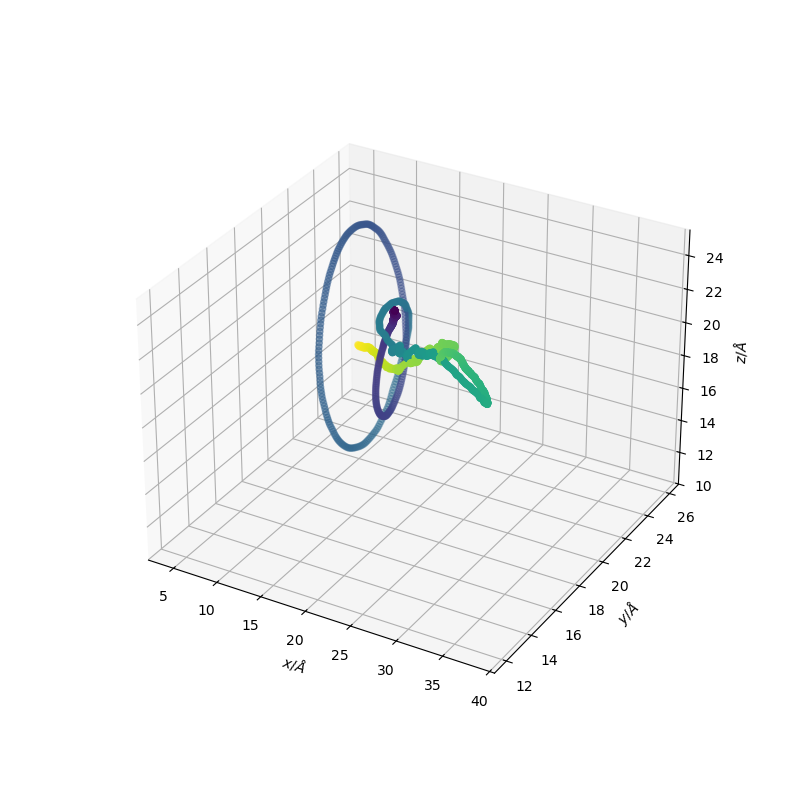

In [11]:
# Convert positions to a three-dimensional numpy array
positions = np.array(particle_positions).squeeze()

# Retrieve positions of methane carbon
c_methane_positions = positions[:, 60, :]
n_times = len(simulation_times)

# Plot trajectory in 3D with colour gradient
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(c_methane_positions[:,0],
             c_methane_positions[:,1],
             c_methane_positions[:,2],
             c=np.linspace(0,1,n_times),
             cmap='viridis')
ax.set_xlabel(r"$x / \AA$")
ax.set_ylabel(r"$y / \AA$")
ax.set_zlabel(r"$z / \AA$")
plt.show()

You can interact with the plot above (provided you've run the first cell of the notebook containing `%matplotlib widget`). Have a play and see if you can spot when:
* the user pulls the methane in a circle
* the user pulls the methane through the nanotube for the first time
* the user pulls the methane through the nanotube for the second time

**Note**: You can replay the trajectory in VR (see optional section at the start of the notebook). This may be useful for interpreting the motion of the methane carbon during the simulation.

## Analysing the user forces

Something of particular interest in iMD simulations is the interactions between the user(s) and the molecular system that bias the dynamics of the molecules. We can extract the user forces from the NanoVer recording (see above), and combine them with the forces from interactions within the molecular system to recover the total forces acting on the atoms. We'll do this for the carbon of the methane that the user interacted with during the simulation, and examine the magnitudes of the various forces acting on it.

**Note**: As with the potential energies of the molecular system and user interaction, NanoVer delivers the forces arising from interactions within the molecular system separately from the forces resulting from user interactions.

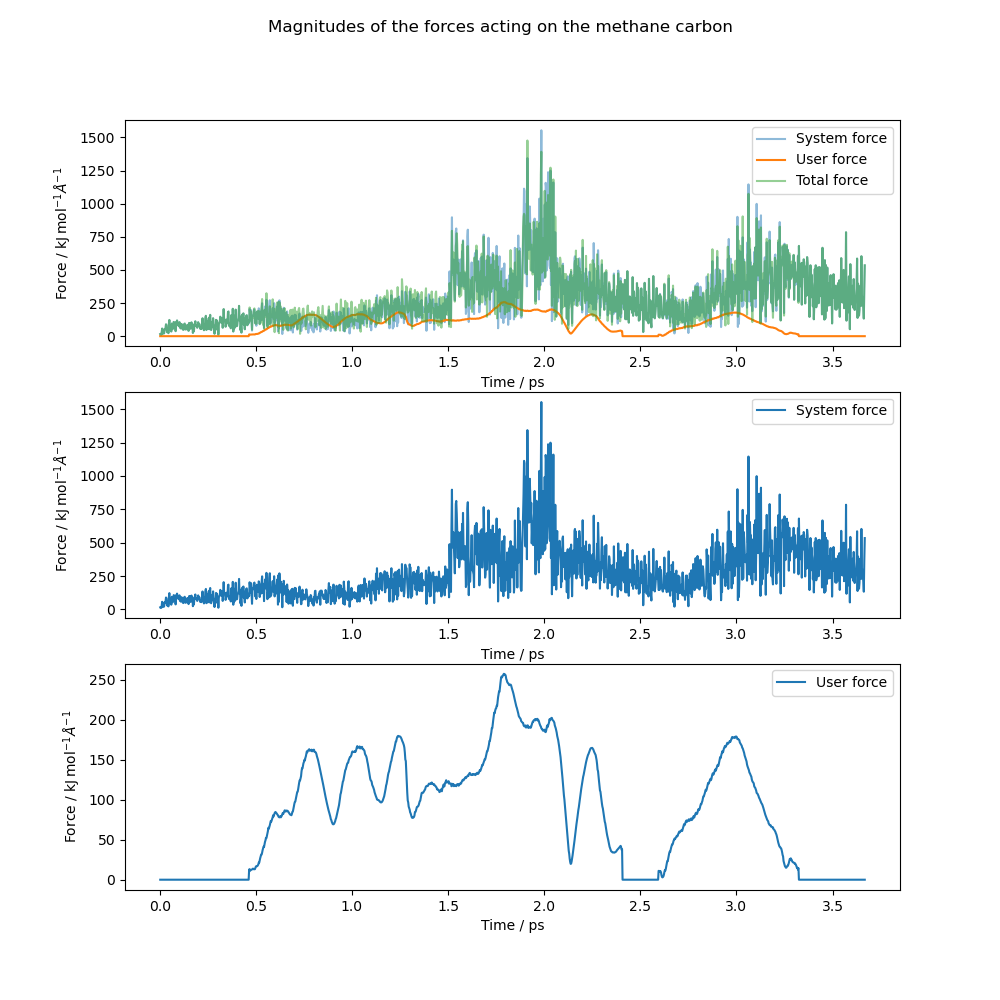

In [12]:
# Convert system and user forces to three-dimensional numpy arrays
forces_system = np.array(particle_forces_system).squeeze()
forces_user = np.array(user_forces).squeeze()

# Retrieve the system and user forces acting on the methane carbon
c_methane_forces_system = forces_system[:, 60, :]
c_methane_forces_user = forces_user[:, 60, :]

# Recover the total force
c_methane_forces_total = c_methane_forces_system + c_methane_forces_user

# Determine magnitudes of the forces
c_methane_forces_system_mag = np.zeros(c_methane_forces_system.shape[0])
c_methane_forces_user_mag = np.zeros(c_methane_forces_user.shape[0])
c_methane_forces_total_mag = np.zeros(c_methane_forces_total.shape[0])

for force in range(len(c_methane_forces_total)):
    c_methane_forces_system_mag[force] = np.linalg.norm(c_methane_forces_system[force])
    c_methane_forces_user_mag[force] = np.linalg.norm(c_methane_forces_user[force])
    c_methane_forces_total_mag[force] = np.linalg.norm(c_methane_forces_total[force])
    
# Plot magnitudes of forces as functions of time
fig, (ax1, ax2, ax3) = plt.subplots(3)

fig.set_figheight(10)
fig.set_figwidth(10)
fig.suptitle('Magnitudes of the forces acting on the methane carbon')

ax1.plot(simulation_times, c_methane_forces_system_mag, label='System force', alpha=0.5)
ax1.plot(simulation_times, c_methane_forces_user_mag, label='User force')
ax1.plot(simulation_times, c_methane_forces_total_mag, label='Total force', alpha=0.5)
ax1.legend()
ax1.set_xlabel("Time / ps")
ax1.set_ylabel(r"Force / $\mathrm{kJ \, mol}^{-1} \AA^{-1}$")

ax2.plot(simulation_times, c_methane_forces_system_mag, label='System force')
ax2.legend()
ax2.set_xlabel("Time / ps")
ax2.set_ylabel(r"Force / $\mathrm{kJ \, mol}^{-1} \AA^{-1}$")

ax3.plot(simulation_times, c_methane_forces_user_mag, label='User force')
ax3.legend()
ax3.set_xlabel("Time / ps")
ax3.set_ylabel(r"Force / $\mathrm{kJ \, mol}^{-1} \AA^{-1}$")

plt.show()

See if you can tell from these plots:
* When the user first applies force to the system
* When the methane enters the nanotube for the first time
* When the methane enters the nanotube for the second time

# Next Steps

* Build your own [VR trajectory viewer](./mdanalysis_trajectory.ipynb) with MDAnalysis and NanoVer
* Learn how to record simulations of your own systems with our [OpenMM polyalanine simulation notebook](../openmm/openmm_polyalanine.ipynb)